# Data Preparation – Bringing data from three different sources together

#### Javier Corpus

Perform at least 5 data transformation and/or cleansing steps to your flat file data.

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/javier/Desktop/Datasets/Full TMDB Movies Dataset 2024/TMDB_movie_dataset_v11.csv')

df.head()


,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [2]:
# Checking the size of the data frame
df.shape

(1193898, 24)

### Milestone 2, Transformation 1: Filter records.

This dataset has 1M+ records, but not all of them have an `IMDB_ID` value. This is the primary key needed to connect these records with the other sources, so the first step will be to remove all the records without an IMDB ID.

We can also remove rows with categories that are not useful for this exercise, such as those movies classified as adult films, documentaries, and films in a primary language other than English.

Records without revenue or budget data can also be removed.

In [3]:
# Dropping all the rows where imdb is NaN or a blank
df_imdb_id = df.dropna(subset=['imdb_id'])
df_imdb_id = df_imdb_id[df_imdb_id['imdb_id'] != '']

# To keep it clean, let's remove all the films identified as adult films.
# Also, let's keep only films where the original language is English.
# We're doing this because Wikipedia doesn't have the filmography of
# many of the actors from other countries.

df_imdb_id = df_imdb_id[df_imdb_id['adult'] == False]
df_imdb_id = df_imdb_id[df_imdb_id['original_language'] == 'en']

# Getting rid of documentaries, as most of them are not starred by actors
df_imdb_id= df_imdb_id[~df_imdb_id['genres'].str.contains('Documentary', case=False, na=False)]

# Getting rid of records without any revenue of budget data.
df_imdb_id = df_imdb_id[df_imdb_id['revenue'] != 0]
df_imdb_id = df_imdb_id[df_imdb_id['budget'] != 0]


# Checking the size of the data frame
df_imdb_id.shape

(8110, 24)

Since the data frame is too big, we're picking a random sample of 1000 records. This is only to prevent issues in future project milestones, because the free API key that we are going to use is limited.

In [4]:
# The random_state value is for reproducibility
df_sample = df_imdb_id.sample(n=1000, random_state=100)

In [5]:
# Checking if there are duplicated rows (all columns)
duplicates = df_sample.duplicated().any()

print(duplicates)

False


In [6]:
# Checking if there are duplicated rows (imdb_id)
duplicates = df_sample.duplicated(subset=['imdb_id']).any()

print(duplicates)

False


### Milestone 2, Transformation 2: Remove unnecessary columns.

Some of the columns are not necessary for this project, such as `id` and `backdrop_path`. We can safely drop them.

In [7]:
df_sample = df_sample.drop(columns=['id', 'adult', 'backdrop_path', 'original_title', 'poster_path', 'keywords'])

### Milestone 2, Transformation 3: New column to determine revenue variance.

If the revenue of a movie exceded its budget, it had a `favorable` revenue. But if the budget was equal or greater than the revenue, then it had an `unfavorable` revenue. We can create a new column showing if the revenue was favorable or unfavorable.

In [8]:
df_sample['revenue_variance'] = np.where(df_sample['revenue'] > df_sample['budget'], 'favorable', 'unfavorable')

### Milestone 2, Transformation 4: Format all the amounts as currency.

The data frame has two numeric columns that are related to money: `revenue` and `budget`. These columns can be formated as currency.

In [9]:
# Function to format a numeric value as currency

def format_currency(x):
    return f"${x:,.2f}"

In [10]:
# Applying the function to format columns as currency:
df_sample['revenue'] = df_sample['revenue'].apply(format_currency)
df_sample['budget'] = df_sample['budget'].apply(format_currency)

### Milestone 2, Transformation 5: Change the order of columns.

Column `imdb_id` is the main key we are going to use in future stages of the project. Let's make that the first column of the data frame instead of the 10th. Let's also put `revenue`, `budget` and `revenue_variance` together.

In [11]:
df_sample = df_sample[['imdb_id', 'title', 'vote_average','status', 'release_date', 'runtime', 'revenue', 'budget', 'revenue_variance', 'homepage', 'original_language', 'overview', 'popularity', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages']]

In [12]:
# Shape of the dataframe (from the flat file)
df_sample.shape

(1000, 18)

In [13]:
# Printing the first five rows of the cleaned data frame.
df_sample.head()

,imdb_id,title,vote_average,status,release_date,runtime,revenue,budget,revenue_variance,homepage,original_language,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages
11395,tt1181614,Wuthering Heights,5.900,Released,2011-09-09,124,"$1,742,215.00","$5,692,172.00",unfavorable,https://www.curzonartificialeye.com/wuthering-...,en,"Yorkshire moorlands, northern England, in the ...",11.745,Love is a force of nature,"Drama, Romance","Ecosse Films, UK Film Council, Film4 Productio...",United Kingdom,English
541,tt1661199,Cinderella,6.798,Released,2015-03-06,105,"$543,514,353.00","$95,000,000.00",favorable,http://movies.disney.com/cinderella,en,"When her father unexpectedly passes away, youn...",58.212,Midnight is just the beginning.,"Romance, Fantasy, Family, Drama","Walt Disney Pictures, Genre Films, Beagle Pug ...","United Kingdom, United States of America",English
7956,tt0102005,Harley Davidson and the Marlboro Man,6.312,Released,1991-08-23,98,"$7,434,726.00","$23,000,000.00",unfavorable,http://www.mgm.com/title_title.do?title_star=H...,en,"It's the lawless future, and renegade biker Ha...",19.835,Who says there are no more heroes?,"Action, Thriller","Krisjair, Laredo, Metro-Goldwyn-Mayer",United States of America,English
17617,tt0047840,Artists and Models,6.800,Released,1955-11-07,110,"$3,800,000.00","$1,500,000.00",favorable,NaN,en,A struggling painter begins taking inspiration...,9.447,"Martin and Lewis run amok with spies, models a...",Comedy,"Hal Wallis Productions, Paramount",United States of America,English
4575,tt0110932,Quiz Show,7.262,Released,1994-08-25,133,"$24,822,619.00","$31,000,000.00",unfavorable,NaN,en,Lawyer Richard Goodwin discovers that 'Twenty-...,13.545,Fifty million people watched but no one saw a ...,"History, Drama, Mystery","Baltimore Pictures, Wildwood Enterprises, Holl...",United States of America,English


## Milestone 2 - Ethical Implications of the transformations of the flat file.

There are no ethical implications in the way this dataset was transformed. The original file contains public information about movies, including the IMDB ID, title, vote average, and revenue, among others. There is no sensitive or personal data.

Some records were filtered out based on their classification (adult films were removed), as well as those whose primary language is different than English. This was done because Wikipedia (Project Milestone 3) does not always have information about adult movie actors, or foreing actors. Leaving these records in the dataset would lead to an incomplete Milestone 3, and removing them does not affect the result at all.

The rest of the transformations work in a similar way: format of currency fields was changed as well as the order of columns, but this doesn't change the outcome.

**What changes were made to the data?**
 - Filtered out adult films.
 - Filtered out films where the main language was not English.
 - Filtered out documentaries.
 - Filtered out films with no budget or revenue reported.
 - Removed unnecessary columns, such as links to movie posters.
 - Added a new column to determine revenue variance.
 - Formatted all the dollar amounts as currency.
 - Changed the order of columns.

**Are there any legal or regulatory guidelines for your data or project topic?**
 - No, this is all public information.

**What risks could be created based on the transformations done?**
 - None. The outcome is the same list of films, with a cleaner format.

**Did you make any assumptions in cleaning/transforming the data?**
 - No assumptions were made.

**How was your data sourced / verified for credibility?**
 - This is public, well-known information about the professional projects of actors.

**Was your data acquired in an ethical way?**
 - Yes, it was acquired in an ethical way.

**How would you mitigate any of the ethical implications you have identified?**
 - No ethical implication was identified.

# Project Milestone 4- Cleaning/Formatting API data.

Perform at least 5 data transformation and/or cleansing steps to your API data

The API will use 100 random records from the dataset (the flat file), it will get the relevant data, and generate Wikipedia URLs based on actor's names. These URLs will be scrapped using BeautifulSoup and Pandas below (Milestone 3).

### Getting the data from the API

In [14]:
# Importing the required libraries
import urllib.request, urllib.parse, urllib.error
import json
import warnings

# Ignore warning messages
warnings.filterwarnings('ignore')

In [15]:
# API Endpoint
apiurl = 'http://www.omdbapi.com/?'

# Opening the APIkeys.json file,
# assigning the API key to variable "omdbapi".
with open('APIkeys.json') as f:
    keys = json.load(f)
    omdbapi = keys['OMDBapi']

apikey = '&apikey=' + omdbapi


# Empty list to store all movie data.
all_movies_data = []

# Defining a function to call the OMDB API using a movie's IMDB ID.
def get_movie_details(movie_id):
    try:
        # Defining the URL as the name of the service ('http://www.omdbapi.com/?'),
        # the movie ID (URL-encoded, just as a safeguard), and the API key
        # read from the APIKeys.json file.
        url = apiurl \
            + urllib.parse.urlencode({'i':str(movie_id)})+apikey

        # Requesting the URL defined above.
        uh = urllib.request.urlopen(url)
        data = uh.read()

        # Getting the JSON response.
        json_data=json.loads(data)

        # If key "Response" is True, append the whole JSON response.
        if json_data['Response']=='True':
            all_movies_data.append(json_data)

        # If a movie is not found, show the error message
        else:
            print(f"Error: {json_data['Error']}")

    # If the "try" block fails, show an error message            
    except urllib.error.URLError as e:
        print(f"ERROR: {e.reason}")

In [16]:
### Getting a sample of 100 random movies IDs (imdb_id)
df_random_movies = df_sample.sample(n = 100, random_state = 100)

for imdb_id in df_random_movies['imdb_id']:
    get_movie_details(imdb_id)

# Creating a dataframe with all the JSON responses
# from the randomly-selected movies.
df_imdb_api = pd.DataFrame(all_movies_data)    

In [17]:
# Checking the shape of the movies dataframe
df_imdb_api.shape

(100, 28)

In [18]:
# Printing the dataframe created from the JSON responses.
df_imdb_api.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Season,Episode,seriesID
0,Driftwood,2012,TV-G,15 Nov 2012,12 min,"Short, Drama, Sport",James Webber,James Webber,"Sam Gittins, Neil Maskell, Daniel Norford","Set in London, Driftwood is the story of fifte...",...,tt2444514,movie,N/A,N/A,N/A,N/A,True,NaN,NaN,NaN
1,Despicable Me 3,2017,PG,30 Jun 2017,89 min,"Animation, Adventure, Comedy","Kyle Balda, Pierre Coffin, Eric Guillon","Cinco Paul, Ken Daurio","Steve Carell, Kristen Wiig, Trey Parker","Gru meets his long-lost, charming, cheerful, a...",...,tt3469046,movie,N/A,"$264,624,300",N/A,N/A,True,NaN,NaN,NaN
2,The Story of Us,1999,R,15 Oct 1999,95 min,"Comedy, Drama, Romance",Rob Reiner,"Alan Zweibel, Jessie Nelson","Bruce Willis, Michelle Pfeiffer, Colleen Rennison",Ben and Katie Jordan are a married couple who ...,...,tt0160916,movie,N/A,"$27,100,031",N/A,N/A,True,NaN,NaN,NaN
3,Buddy,1997,PG,06 Jun 1997,84 min,"Adventure, Comedy, Drama",Caroline Thompson,"Gertrude Davies Lintz, William Joyce, Caroline...","Rene Russo, Robbie Coltrane, Alan Cumming",A depiction of the true life story of Gertrude...,...,tt0118787,movie,N/A,"$10,113,400",N/A,N/A,True,NaN,NaN,NaN
4,The Gods Must Be Crazy,1980,PG,26 Oct 1984,109 min,"Adventure, Comedy",Jamie Uys,Jamie Uys,"N!xau, Marius Weyers, Sandra Prinsloo",A comic allegory about a traveling Bushman who...,...,tt0080801,movie,N/A,"$30,031,783",N/A,N/A,True,NaN,NaN,NaN


### Milestone 4, Transformation 1: Adding new columns.

The API returns a field called "Actors" with the names of the three main actors of a movie. We are going to separate these into individual columns called "Actor 1", "Actor 2", and "Actor 3".

In [19]:
# Splitting the "Actors" names by comma and a blank space.
# Adding these names into new columns
df_imdb_api[['Actor 1', 'Actor 2', 'Actor 3']] = df_imdb_api['Actors'].str.split(', ', expand=True, n=2)

In [20]:
df_imdb_api.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,BoxOffice,Production,Website,Response,Season,Episode,seriesID,Actor 1,Actor 2,Actor 3
0,Driftwood,2012,TV-G,15 Nov 2012,12 min,"Short, Drama, Sport",James Webber,James Webber,"Sam Gittins, Neil Maskell, Daniel Norford","Set in London, Driftwood is the story of fifte...",...,N/A,N/A,N/A,True,NaN,NaN,NaN,Sam Gittins,Neil Maskell,Daniel Norford
1,Despicable Me 3,2017,PG,30 Jun 2017,89 min,"Animation, Adventure, Comedy","Kyle Balda, Pierre Coffin, Eric Guillon","Cinco Paul, Ken Daurio","Steve Carell, Kristen Wiig, Trey Parker","Gru meets his long-lost, charming, cheerful, a...",...,"$264,624,300",N/A,N/A,True,NaN,NaN,NaN,Steve Carell,Kristen Wiig,Trey Parker
2,The Story of Us,1999,R,15 Oct 1999,95 min,"Comedy, Drama, Romance",Rob Reiner,"Alan Zweibel, Jessie Nelson","Bruce Willis, Michelle Pfeiffer, Colleen Rennison",Ben and Katie Jordan are a married couple who ...,...,"$27,100,031",N/A,N/A,True,NaN,NaN,NaN,Bruce Willis,Michelle Pfeiffer,Colleen Rennison
3,Buddy,1997,PG,06 Jun 1997,84 min,"Adventure, Comedy, Drama",Caroline Thompson,"Gertrude Davies Lintz, William Joyce, Caroline...","Rene Russo, Robbie Coltrane, Alan Cumming",A depiction of the true life story of Gertrude...,...,"$10,113,400",N/A,N/A,True,NaN,NaN,NaN,Rene Russo,Robbie Coltrane,Alan Cumming
4,The Gods Must Be Crazy,1980,PG,26 Oct 1984,109 min,"Adventure, Comedy",Jamie Uys,Jamie Uys,"N!xau, Marius Weyers, Sandra Prinsloo",A comic allegory about a traveling Bushman who...,...,"$30,031,783",N/A,N/A,True,NaN,NaN,NaN,N!xau,Marius Weyers,Sandra Prinsloo


### Milestone 4, Transformation 2: Removing the "Actors" column.

Since we already separated the actor names into individual columns, the original "Actors" column is no longer needed.

In [21]:
 # Deleting the "Actors" column.
 df_imdb_api = df_imdb_api.drop(columns=['Actors'])

### Milestone 4, Transformation 3: Transforming "Year" and "Released" from String to Datetime.

In [22]:
# First, let's check the actual type of the variables
Year_Type = df_imdb_api['Year'].dtype
Released_Type = df_imdb_api['Released'].dtype

print(f'Year Type: {Year_Type}')
print(f'Released Type: {Released_Type}')

Year Type: object
Released Type: object


In [23]:
# Since both columns are type `object` (string), we need to convert them to dates
df_imdb_api['Year'] = pd.to_datetime(df_imdb_api['Year'], errors='coerce')
df_imdb_api['Released'] = pd.to_datetime(df_imdb_api['Released'], errors='coerce')

# Checking the actual type of the variables after the conversion
Year_Type = df_imdb_api['Year'].dtype
Released_Type = df_imdb_api['Released'].dtype

print(f'Year Type: {Year_Type}')
print(f'Released Type: {Released_Type}')

Year Type: datetime64[ns]
Released Type: datetime64[ns]


### Milestone 4, Transformation 4: Converting the "BoxOffice" column to numeric values.

In [24]:
# Function to remove the "$" and "," chars.
def convert_box_office(value):
    if isinstance(value, str):
        
        # Remove dollar sign and commas
        value = value.replace('$', '').replace(',', '')
    return pd.to_numeric(value, errors='coerce')

In [25]:
# First, let's check the actual type of the variables

# This can also be done with:
# BoxOffice_Type = df_imdb_api['BoxOffice'].dtype
# print(f'Box Office Type: {BoxOffice_Type}')

# Before the transformation:
df_imdb_api['BoxOffice'].head()

0             N/A
1    $264,624,300
2     $27,100,031
3     $10,113,400
4     $30,031,783
Name: BoxOffice, dtype: object

In [26]:
# Applying the function to the BoxOffice column
df_imdb_api['BoxOffice'] = df_imdb_api['BoxOffice'].apply(convert_box_office)

In [27]:
# Checking the data type after the conversion.
df_imdb_api['BoxOffice'].head()

0            NaN
1    264624300.0
2     27100031.0
3     10113400.0
4     30031783.0
Name: BoxOffice, dtype: float64

### Milestone 4, Transformation 5: Converting "Runtime" from string to numeric.

In [28]:
df_imdb_api['Runtime_min'] = df_imdb_api['Runtime'].str.extract('(\d+)').astype(float)

# Deleting column "Runtime"
df_imdb_api = df_imdb_api.drop(columns=['Runtime'])

df_imdb_api.head()

,Title,Year,Rated,Released,Genre,Director,Writer,Plot,Language,Country,...,Production,Website,Response,Season,Episode,seriesID,Actor 1,Actor 2,Actor 3,Runtime_min
0,Driftwood,2012-01-01,TV-G,2012-11-15,"Short, Drama, Sport",James Webber,James Webber,"Set in London, Driftwood is the story of fifte...",English,United Kingdom,...,N/A,N/A,True,NaN,NaN,NaN,Sam Gittins,Neil Maskell,Daniel Norford,12.0
1,Despicable Me 3,2017-01-01,PG,2017-06-30,"Animation, Adventure, Comedy","Kyle Balda, Pierre Coffin, Eric Guillon","Cinco Paul, Ken Daurio","Gru meets his long-lost, charming, cheerful, a...",English,"United States, France",...,N/A,N/A,True,NaN,NaN,NaN,Steve Carell,Kristen Wiig,Trey Parker,89.0
2,The Story of Us,1999-01-01,R,1999-10-15,"Comedy, Drama, Romance",Rob Reiner,"Alan Zweibel, Jessie Nelson",Ben and Katie Jordan are a married couple who ...,"English, Italian",United States,...,N/A,N/A,True,NaN,NaN,NaN,Bruce Willis,Michelle Pfeiffer,Colleen Rennison,95.0
3,Buddy,1997-01-01,PG,1997-06-06,"Adventure, Comedy, Drama",Caroline Thompson,"Gertrude Davies Lintz, William Joyce, Caroline...",A depiction of the true life story of Gertrude...,English,United States,...,N/A,N/A,True,NaN,NaN,NaN,Rene Russo,Robbie Coltrane,Alan Cumming,84.0
4,The Gods Must Be Crazy,1980-01-01,PG,1984-10-26,"Adventure, Comedy",Jamie Uys,Jamie Uys,A comic allegory about a traveling Bushman who...,"English, Afrikaans, Ungwatsi","South Africa, Botswana",...,N/A,N/A,True,NaN,NaN,NaN,N!xau,Marius Weyers,Sandra Prinsloo,109.0


## Needed for Project Milestone 3:

Create a new dataframe called "df_actors". It will have the name of the actors and their filmography URL in Wikipedia. This is going to be used in the milestone below.

In [29]:
# Importing the required libraries.
import requests
from urllib.parse import quote


# Step 1: Creating the "df_actors" dataframe with all unique actors.
actor_columns = ['Actor 1', 'Actor 2', 'Actor 3']
df_actors = pd.DataFrame({
    'Actor': df_imdb_api[actor_columns].stack().unique()
}).reset_index(drop=True)

# Step 2: Finding Wikipedia filmography URLs
def find_wikipedia_url(actor_name):
    base_url = "https://en.wikipedia.org/wiki/"

    # Replacing blank spaces with underscores.
    name_encoded = actor_name.replace(' ', '_')
    
    # Common filmography URL patterns
    url_patterns = [

        # e.g. https://en.wikipedia.org/wiki/List_of_Samuel_L._Jackson_performances
        f"List_of_{name_encoded}_performances",
        # e.g. https://en.wikipedia.org/wiki/Keanu_Reeves_filmography
        f"{name_encoded}_filmography",

        # e.g. https://en.wikipedia.org/wiki/Mark_Ruffalo_on_screen_and_stage
        f"{name_encoded}_on_screen_and_stage",

        # e.g. https://en.wikipedia.org/wiki/Carrie-Anne_Moss
        f"{name_encoded}"
    ]
    
    for pattern in url_patterns:
        url = base_url + pattern
        try:
            response = requests.get(url, timeout=5)

            # Check each specified pattern, return the one
            # with a response status code 200.
            if response.status_code == 200:
                return url
        except requests.exceptions.RequestException:
            continue
    
    # Filmography URL was not found
    return None

In [30]:
# Searching for each actor's filmography
# This can take several minutes to run
df_actors['Wiki_url'] = df_actors['Actor'].apply(find_wikipedia_url)

In [31]:
# Deleting rows where no filmography URL was found.
df_actors = df_actors.dropna(subset=['Wiki_url'])

In [32]:
# This is the dataframe that can be used in Milestone 3.
df_actors

,Actor,Wiki_url
1,Neil Maskell,https://en.wikipedia.org/wiki/Neil_Maskell
3,Steve Carell,https://en.wikipedia.org/wiki/Steve_Carell_fil...
4,Kristen Wiig,https://en.wikipedia.org/wiki/Kristen_Wiig
5,Trey Parker,https://en.wikipedia.org/wiki/Trey_Parker_film...
6,Bruce Willis,https://en.wikipedia.org/wiki/Bruce_Willis_fil...
...,...,...
275,Fares Fares,https://en.wikipedia.org/wiki/Fares_Fares
276,Mari Malek,https://en.wikipedia.org/wiki/Mari_Malek
278,Donald Glover,https://en.wikipedia.org/wiki/Donald_Glover
279,Beyoncé,https://en.wikipedia.org/wiki/List_of_Beyoncé_...


## Milestone 4 - Ethical Implications

There are no ethical implications with the trasnformations performed with the information returned by the API. All the information contained there is public, related to work projects of actors. The trasformations done do not affect the outcome, the list of films remains the same, but cleaner.

**What changes were made to the data?**
 - Added a new columns with the names of the main actors (one per column).
 - Removed columns that are no longer necessary ("actors").
 - Converted "Year" and "Released" to datetime objects.
 - Converted BoxOffice from string to numeric.
 - Converted Runtime from sting to numeric.

**Are there any legal or regulatory guidelines for your data or project topic?**
 - No, this is all public information.

**What risks could be created based on the transformations done?**
 - None. The outcome is the same list of films, with a cleaner format.

**Did you make any assumptions in cleaning/transforming the data?**
 - No assumptions were made.

**How was your data sourced / verified for credibility?**
 - This is public, well-known information about the professional projects of actors.

**Was your data acquired in an ethical way?**
 - Yes, it was acquired in an ethical way.

**How would you mitigate any of the ethical implications you have identified?**
 - No ethical implication was identified.


# Project Milestone 3 - Cleaning/Formatting website data.

Perform at least 5 data transformation and/or cleansing steps to your website data.

---

In [33]:
# Importing libraries and harcoding URLs to scrape.

import pandas as pd
from bs4 import BeautifulSoup
import requests
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')
    

In [34]:
# Getting actor names from the dataframe created in Milestone 4
actor_names = df_actors['Actor']

actor_names

1       Neil Maskell
3       Steve Carell
4       Kristen Wiig
5        Trey Parker
6       Bruce Willis
           ...      
275      Fares Fares
276       Mari Malek
278    Donald Glover
279          Beyoncé
280       Seth Rogen
Name: Actor, Length: 245, dtype: object

### Milestone 3, Transformation 1: Adding new colum.

The filmography data scraped from Wikipedia does not include the name of the actor. We are including it.

### Milestone 3, Transformation 2: Renaming columns.

For some actors (like Samuel. L. Jackson), the table has column names like "Role" and "Ref." For other actors (like Keanu Reeves), the columns are called "Role(s)" and "Ref(s)." This causes issues when merging the dataframes, because Pandas consider "Role" and "Role(s)" to be different columns. They need to be standardized.

Both of these transformations are done in the function defined below.

In [35]:
# Function to return the filmography as dataframe.
def get_filmography(actor):

    # This Try/Except block is because the filmography is
    # not always found, like when two persons have the same
    # name but only one is an actor.
    try:
        # Using actor name as key to get the URL
        #url = urls[actor]
        url = df_actors.loc[df_actors['Actor'] == actor, 'Wiki_url'].values[0]

        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Finding the tables
        table = soup.find('table', {'class': 'wikitable'})

        dfs = pd.read_html(str(table))

        # Getting the first table
        df = dfs[0]

        # Some column names are different, we want them to be standardized.
        df = df.rename(columns={
            'Role(s)': 'Role',
            'Ref(s)': 'Ref.',
        })

        # Adding actor name
        df['Actor'] = actor

        return df
    except:
        print(f'Filmography not found for: {actor} using url {url}')    

### Milestone 3, Transformation 3: Merging all the dataframes into a single one.

The filmography of each actor comes in a different dataframe. We want them combined into a single one; this will make future milestones easier when we create visualizations and we store everything in a database.

In [36]:
# New dataframe to store all films
df_films = pd.DataFrame(columns = ['Year', 'Title', 'Role', 'Notes', 'Ref.'])

# List to store individual dataframes
filmography_dfs = []

for actor in actor_names:
    df_filmography = get_filmography(actor)
    filmography_dfs.append(df_filmography)

# Concatenate all dataframes into a single one
df_films = pd.concat(filmography_dfs, ignore_index=True)


Filmography not found for: Marius Weyers using url https://en.wikipedia.org/wiki/Marius_Weyers
Filmography not found for: Sandra Prinsloo using url https://en.wikipedia.org/wiki/Sandra_Prinsloo
Filmography not found for: Marti Belle using url https://en.wikipedia.org/wiki/Marti_Belle
Filmography not found for: Rachael Ellering using url https://en.wikipedia.org/wiki/Rachael_Ellering
Filmography not found for: Mayu Iwatani using url https://en.wikipedia.org/wiki/Mayu_Iwatani
Filmography not found for: Victor Wong using url https://en.wikipedia.org/wiki/Victor_Wong
Filmography not found for: Max Elliott Slade using url https://en.wikipedia.org/wiki/Max_Elliott_Slade
Filmography not found for: Jennifer Buckley using url https://en.wikipedia.org/wiki/Jennifer_Buckley
Filmography not found for: Sean Curran using url https://en.wikipedia.org/wiki/Sean_Curran
Filmography not found for: Andrey Makarov using url https://en.wikipedia.org/wiki/Andrey_Makarov
Filmography not found for: N/A using u

In [37]:
df_films

,Year,Title,Role,Notes,Actor,"(Year, Year)","(Title, Title)","(Functioned as, Director)","(Functioned as, Writer)","(Functioned as, Producer)",...,Title[14][15],"(Film, Year)","(Film, Title)","(Film, Role)","(Film, Notes)",Associated album(s),Continent(s),Shows,Gross,Attendance
0,1997,Nil by Mouth,Schmuddie,NaN,Neil Maskell,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997,Crocodile Snap,Ray,Short film,Neil Maskell,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998,Titanic Town,Soldier,NaN,Neil Maskell,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,Sorted,Record Shop Geezer,NaN,Neil Maskell,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,Redemption Road,Leading Mugger,NaN,Neil Maskell,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9288,2023,Cobweb,NaN,NaN,Seth Rogen,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9289,2023,Teenage Mutant Ninja Turtles: Mutant Mayhem,NaN,NaN,Seth Rogen,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9290,2024,Miller's Girl,NaN,NaN,Seth Rogen,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9291,TBA,4 Kids Walk Into a Bank,NaN,NaN,Seth Rogen,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Milestone 3, Transformation 4: Dropping columns that are not necessary.

Columns 'Notes' and 'Ref' are not necessary. These columns don't add anything useful to the dataframe, and they won't be used in future milestones.

In [38]:
df_films = df_films.drop(columns=['Notes', 'Ref.'])

### Milestone 3, Transformation 5: Converting Years from strings to dates.

Column "Year" is stored as string. We need to transform them to dates

In [39]:
# First, let's check the actual type of the column
Year_Type = df_films['Year'].dtype
print(f'Object Year Type: {Year_Type}')

Object Year Type: object


In [40]:
# Since Year is type `object` (string), we need to convert it to dates
# Using errors='ignore' to presenve the original value of non-dates (e.g. TBA)
df_films['Year'] = pd.to_datetime(df_films['Year'], format='%Y', errors='coerce')
df_films['Year'] = df_films['Year'].dt.to_period('Y')

# Checking the actual type of the column after the conversion
Year_Type = df_films['Year'].dtype
print(f'Object Year Type: {Year_Type}')

Object Year Type: period[Y-DEC]


### Milestone 3, Transformation 6: Change the order of columns

The 'Actor' column is currencly the last one of the dataframe. It makes more sense to have it at first, since we will be looking at the filmography of each actor.

In [41]:
df_films = df_films[['Actor', 'Year', 'Title','Role']]

### Milestone 3, Transformation 7: Remove "†" symbols.

Wikipedia adds a small cross-like symbol (†) to titles that have not been released yet. We need to clean it up (when applicable).

For example, Keanu Reeve's filmography has four unreleased movies (as of May 2025).

In [42]:
# Before clean up:
df_films.tail(2)

,Actor,Year,Title,Role
9291,Seth Rogen,NaT,4 Kids Walk Into a Bank,NaN
9292,Seth Rogen,NaT,The Wrong Girls,NaN


In [43]:
# Replacing this symbol with an empty string.
df_films['Title'] = df_films['Title'].str.replace('†', '', regex=False)

In [44]:
# After clean up:
df_films.tail(2)

,Actor,Year,Title,Role
9291,Seth Rogen,NaT,4 Kids Walk Into a Bank,NaN
9292,Seth Rogen,NaT,The Wrong Girls,NaN


In [45]:
# Final dataframe.
df_films

,Actor,Year,Title,Role
0,Neil Maskell,1997,Nil by Mouth,Schmuddie
1,Neil Maskell,1997,Crocodile Snap,Ray
2,Neil Maskell,1998,Titanic Town,Soldier
3,Neil Maskell,2000,Sorted,Record Shop Geezer
4,Neil Maskell,2001,Redemption Road,Leading Mugger
...,...,...,...,...
9288,Seth Rogen,2023,Cobweb,NaN
9289,Seth Rogen,2023,Teenage Mutant Ninja Turtles: Mutant Mayhem,NaN
9290,Seth Rogen,2024,Miller's Girl,NaN
9291,Seth Rogen,NaT,4 Kids Walk Into a Bank,NaN


## Milestone 3 - Ethical Implications

Just like Milestone 2, there are no ethical implications with the trasnformations performed with the Wikipedia tables. All the information contained there is public, related to work projects of actors. The trasformations done do not affect the outcome, the list of films remains the same, but cleaner.

**What changes were made to the data?**
 - Added a new column with the actor's name.
 - Standardized the column names (e.g. 'Role' and 'Role(s)').
 - Merged distinct dataframes into one.
 - Dropped colums that are not necessary (notes and references).
 - Converted Year from string to date.
 - Changed the order of columns.
 - Removed "†" symbols from Titles.

**Are there any legal or regulatory guidelines for your data or project topic?**
 - No, this is all public information.

**What risks could be created based on the transformations done?**
 - None. The outcome is the same list of films, with a cleaner format.

**Did you make any assumptions in cleaning/transforming the data?**
 - No assumptions were made.

**How was your data sourced / verified for credibility?**
 - This is public, well-known information about the professional projects of actors.

**Was your data acquired in an ethical way?**
 - Yes, it was acquired in an ethical way.

**How would you mitigate any of the ethical implications you have identified?**
 - No ethical implication was identified.


# Project Milestone 5 - Merging the Data and Storing in a Database/Visualizing Data.

Checking the number of total columns and rows for all the datasets.

In [46]:
df_sample_cols = df_sample.shape[1]
df_sample_rows = df_sample.shape[0]
df_imdb_api_cols = df_imdb_api.shape[1]
df_imdb_api_rows = df_imdb_api.shape[0]
df_films_cols = df_films.shape[1]
df_films_rows = df_films.shape[0]

print('Total columns and rows in all dataframes')
print('----------------------------------------')
print(f'Columns: {df_sample_cols + df_imdb_api_cols + df_films_cols}')
print(f'Rows: {df_sample_rows + df_imdb_api_rows + df_films_rows}')

Total columns and rows in all dataframes
----------------------------------------
Columns: 52
Rows: 10393


Creating a SQLite database to store all three dataframes.

In [47]:
# Importing required libraries
import sqlite3
import pandas as pd

# Name of the SQLite database
db_name = 'DSC540_Data_Preparation.db'

try:
    # Creating a connection to the database.
    conn = sqlite3.connect(db_name)
        
    print(f'Database {db_name} created')
            
except Exception as e:
    # If there was an error, display it.
    print(f"An error occurred while creating the database: {e}")

Database DSC540_Data_Preparation.db created


Defining a function to create a table from a given dataframe.

In [48]:
# Function to create a table from a dataframe
def create_table_from_dataframe(table_name, df):
    try:
        # Insert records from dataframe into table.
        # If the table already exist, replace.
        df.to_sql(table_name, conn, if_exists='replace', index=False)

        print(f'Successfully created table {table_name}.')
        print(f'Imported {len(df)} records.')
    
    except Exception as e:
        print(f"An error occurred while creating the table {table_name}: {e}")    


## Milestone 5, Step 1 - Storing the flat file in a SQLite database.

In [49]:
create_table_from_dataframe('flat_file', df_sample)

Successfully created table flat_file.
Imported 1000 records.


## Milestone 5, Step 2 - Storing the API results in a SQLite database.

In [50]:
# The 'Ratings' column is a list of different ratings.
# SQLite cannot handle this type of columns, but we can
# safetely drop it, since it won't be needed.
df_imdb_api = df_imdb_api.drop(columns=['Ratings'])

# Creating the table from the API results
create_table_from_dataframe('api_file', df_imdb_api)

Successfully created table api_file.
Imported 100 records.


## Milestone 5, Step 3 - Storing the Wikipedia tables in a SQLite database.

In [51]:
# Checking the type of field Year
print(df_films['Year'].dtype)

period[Y-DEC]


In [52]:
# SQLite cannot handle the "Period" type. We need to convert it to datetime.
df_films['Year'] = df_films['Year'].dt.to_timestamp()

In [53]:
# Making sure it got converted to datetime.
print(df_films['Year'].dtype)

datetime64[ns]


In [54]:
# Creating the SQLite table from the Wikipedia tables.
create_table_from_dataframe('wiki_file', df_films)

Successfully created table wiki_file.
Imported 9293 records.


## Milestone 5, Step 4 - Joining all tables into one with SQL statements, store the result in a new dataframe.

In [55]:
# SQL query to join the tables.

# "A" is the alias for the table created from the API.
# "F" is the alias for the table created from the Flat file.
# "W" is the alias for the table created from the Web (Wikipedia).
# There are three sub-queries to get the total count of movies per
# actor listed in the API table.
query = """
SELECT 
    A.imdbID,
    A.Title,
    A.Runtime_min,
    A.Year,
    A.Rated,
    A.Released,
    A.Genre,
    A.Director,
    A.Writer,
    A.Plot,
    A.Language,
    A.Country,
    A.Awards,
    A.imdbRating,
    A.imdbVotes,
    A.'Actor 1',
    (SELECT COUNT(*) FROM wiki_file WHERE Actor = A.'Actor 1') AS Total_Movies_A1,
    A.'Actor 2',
    (SELECT COUNT(*) FROM wiki_file WHERE Actor = A.'Actor 2') AS Total_Movies_A2,
    A.'Actor 3',
    (SELECT COUNT(*) FROM wiki_file WHERE Actor = A.'Actor 3') AS Total_Movies_A3,
    F.popularity,
    F.revenue,
    F.budget,
    F.revenue_variance,
    F.production_companies,
    F.production_countries
FROM 
    api_file AS A
INNER JOIN 
    flat_file AS F ON A.imdbID = F.imdb_ID
"""

# Executing the query and saving the results to a new dataframe.
df_tables_joined = pd.read_sql_query(query, conn)

# Displaying the first five rows of the new dataframe (tables joined).
# This dataframe displays general information about a movie from the flat file,
# the three main actors of each movie as per the API results,
# and the total count of movies for each one of these actors, as per Wikipedia.
df_tables_joined.head()

,imdbID,Title,Runtime_min,Year,Rated,Released,Genre,Director,Writer,Plot,...,Actor 2,Total_Movies_A2,Actor 3,Total_Movies_A3,popularity,revenue,budget,revenue_variance,production_companies,production_countries
0,tt2444514,Driftwood,12.0,2012-01-01 00:00:00,TV-G,2012-11-15 00:00:00,"Short, Drama, Sport",James Webber,James Webber,"Set in London, Driftwood is the story of fifte...",...,Neil Maskell,61,Daniel Norford,0,0.600,"$30,000.00","$30,000.00",unfavorable,The Springhead Film Company,United Kingdom
1,tt3469046,Despicable Me 3,89.0,2017-01-01 00:00:00,PG,2017-06-30 00:00:00,"Animation, Adventure, Comedy","Kyle Balda, Pierre Coffin, Eric Guillon","Cinco Paul, Ken Daurio","Gru meets his long-lost, charming, cheerful, a...",...,Kristen Wiig,54,Trey Parker,0,29.104,"$1,031,552,585.00","$80,000,000.00",favorable,"Illumination, Universal Pictures",United States of America
2,tt0160916,The Story of Us,95.0,1999-01-01 00:00:00,R,1999-10-15 00:00:00,"Comedy, Drama, Romance",Rob Reiner,"Alan Zweibel, Jessie Nelson",Ben and Katie Jordan are a married couple who ...,...,Michelle Pfeiffer,1,Colleen Rennison,14,15.488,"$58,900,031.00","$50,000,000.00",favorable,"Universal Pictures, Castle Rock Entertainment,...",United States of America
3,tt0118787,Buddy,84.0,1997-01-01 00:00:00,PG,1997-06-06 00:00:00,"Adventure, Comedy, Drama",Caroline Thompson,"Gertrude Davies Lintz, William Joyce, Caroline...",A depiction of the true life story of Gertrude...,...,Robbie Coltrane,57,Alan Cumming,71,7.084,"$10,113,400.00","$25,000,000.00",unfavorable,"Columbia Pictures, The Jim Henson Company, Jim...",United States of America
4,tt0080801,The Gods Must Be Crazy,109.0,1980-01-01 00:00:00,PG,1984-10-26 00:00:00,"Adventure, Comedy",Jamie Uys,Jamie Uys,A comic allegory about a traveling Bushman who...,...,Marius Weyers,0,Sandra Prinsloo,0,18.957,"$60,000,000.00","$5,000,000.00",favorable,"CAT Films, Mimosa Films","South Africa, Botswana"


## Milestone 5, Step 6 - Visualizations.

**Note:** Most of these visualizations are based on the data from the `api_file` table, which has a few randomly selected records. These are **not** based on the whole dataset, which contains 1M+ records.

#### Visualization 1 - Top 5 Highest Rated Movies by IMDb Rating (api_file + flat_file)

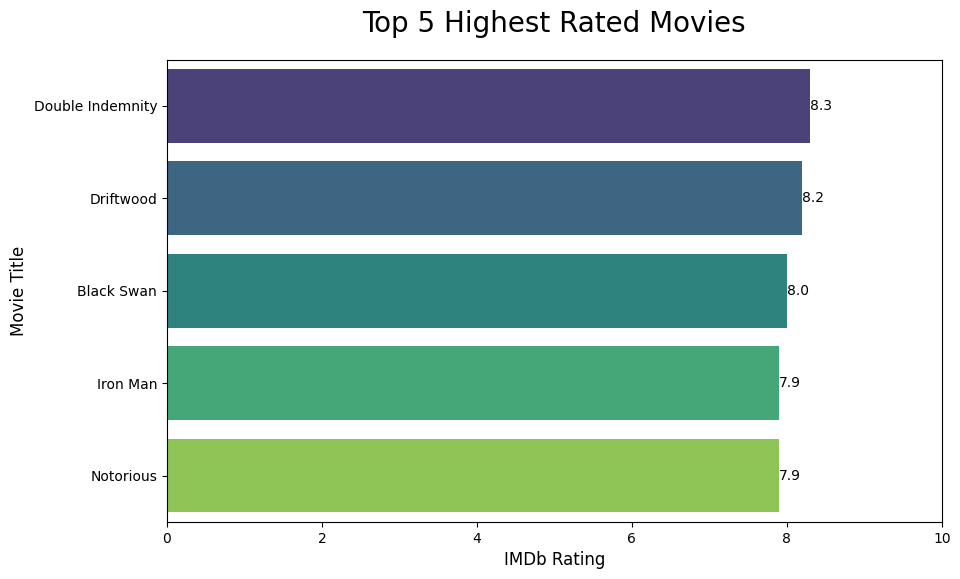

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Query to get movie ratings.
query1 = """
SELECT F.title, A.imdbRating
FROM api_file A
JOIN flat_file F ON A.imdbID = F.imdb_id
WHERE A.imdbRating != 'N/A'
"""

# Saving the results of the query into a dataframe.
df1 = pd.read_sql(query1, conn)

# Converting imdbRating to numerical.
df1['imdbRating'] = pd.to_numeric(df1['imdbRating'])

# Handle duplicates - keeping highest rated version of each movie
df1 = df1.sort_values('imdbRating', ascending=False).drop_duplicates('title')

# Getting top 5 after deduplication
df1 = df1.nlargest(5, 'imdbRating').sort_values('imdbRating', ascending=False)

# Creating plot
plt.figure(figsize=(10,6))
barplot = sns.barplot(
    x='imdbRating', 
    y='title', 
    data=df1, 
    palette='viridis',
    hue='title',
    order=df1['title']
)

# Adding value labels to each bar.
for index, value in enumerate(df1['imdbRating']):
    barplot.text(value, index, f'{value:.1f}', color='black', ha="left", va="center")

plt.title('Top 5 Highest Rated Movies', fontsize=20, pad=20)
plt.xlabel('IMDb Rating', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.xlim(0,10) # Setting x-axis limits from 0 to 10
plt.show()

#### Visualization 2 - Revenue vs. IMDb Rating for Movies (api_file + flat_file)

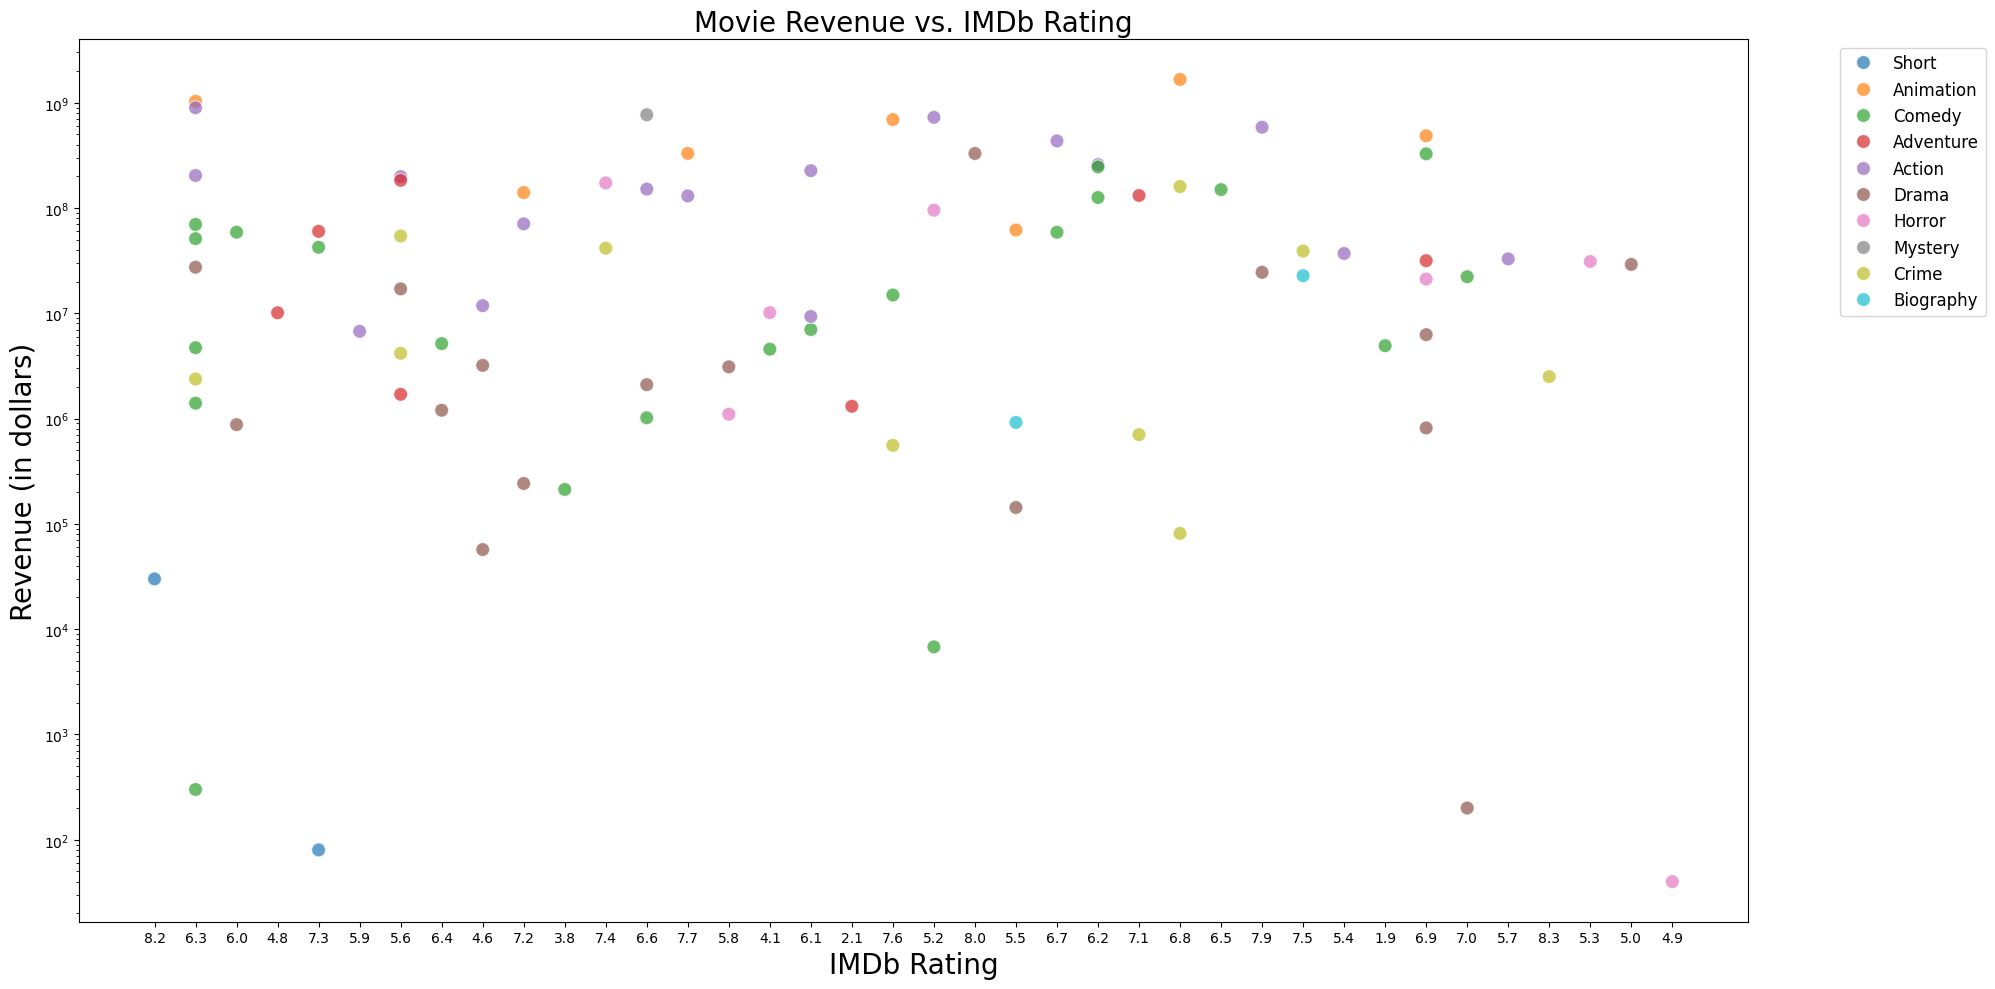

In [57]:
# Query to join tables and get revenue vs rating.
query2 = """
SELECT F.title, A.imdbRating, 
       CAST(REPLACE(REPLACE(F.revenue, '$', ''), ',', '') AS FLOAT) AS revenue_num,
       A.Genre
FROM api_file A
JOIN flat_file F ON A.imdbID = F.imdb_id
WHERE A.imdbRating != 'N/A' AND F.revenue != ''
"""

# Storing the result of the query into a dataframe.
df2 = pd.read_sql(query2, conn)

# Getting only the first genre listed, for simplicity.
df2['Primary_Genre'] = df2['Genre'].str.split(',').str[0]

# Scatter Plot
plt.figure(figsize=(20,10))
sns.scatterplot(x='imdbRating',
                y='revenue_num',
                hue='Primary_Genre',
                data=df2,
                alpha=0.7,
                s=100)
plt.title('Movie Revenue vs. IMDb Rating', fontsize=20)
plt.xlabel('IMDb Rating', fontsize=20)
plt.ylabel('Revenue (in dollars)', fontsize=20)
plt.yscale('log')  # We are using Log Scale for better visualization.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

#### Visualization 3 - Actors with Most Appearances in High-Rated Movies (api_file + wiki_file)

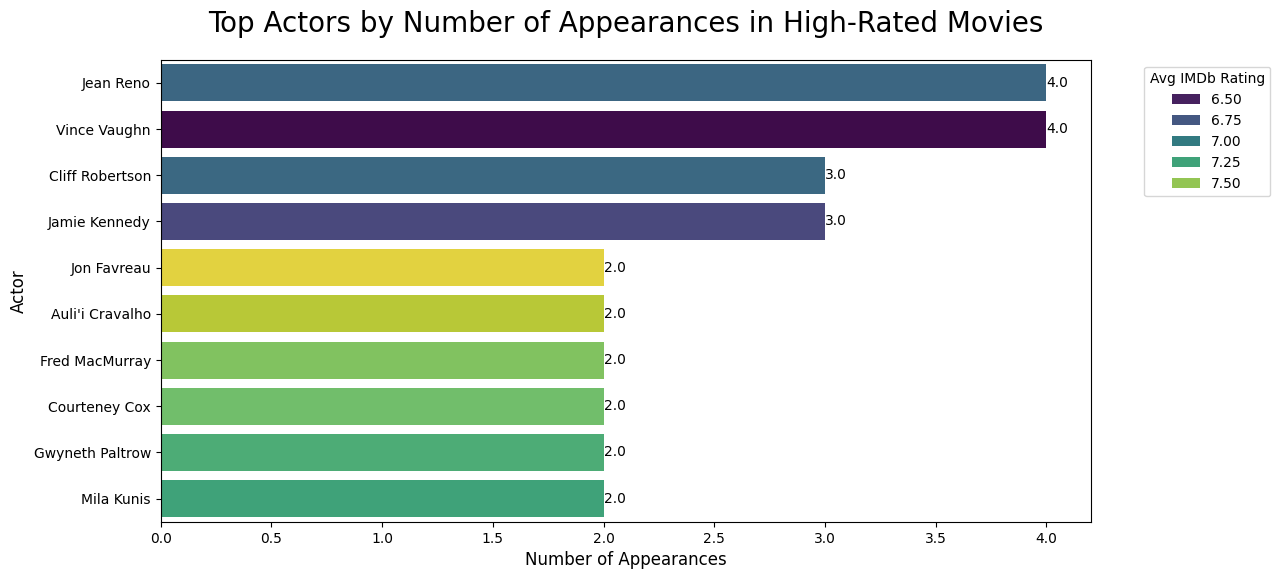

In [58]:
# Query to count actor appearances in high-rated movies.
query3 = """
SELECT W.Actor, COUNT(*) as appearance_count, 
       AVG(CAST(A.imdbRating AS FLOAT)) as avg_rating
FROM wiki_file W
JOIN api_file A ON W.Title = A.Title
WHERE A.imdbRating != 'N/A'
GROUP BY W.Actor
HAVING COUNT(*) > 1
ORDER BY appearance_count DESC, avg_rating DESC
LIMIT 10
"""
# Storing the result of the query into a dataframe.
df3 = pd.read_sql(query3, conn)

# Visualization
plt.figure(figsize=(12,6))
barplot = sns.barplot(x='appearance_count',
            y='Actor',
            hue='avg_rating',
            data=df3,
            palette='viridis',
            dodge=False)

# Adding value labels to each bar.
for index, value in enumerate(df3['appearance_count']):
    barplot.text(value, index, f'{value:.1f}', color='black', ha="left", va="center")

plt.title('Top Actors by Number of Appearances in High-Rated Movies', fontsize=20, pad=20)
plt.xlabel('Number of Appearances', fontsize=12)
plt.ylabel('Actor', fontsize=12)
plt.legend(title='Avg IMDb Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Visualization 4 - Runtime vs. Revenue by Genre (api_file + flat_file)

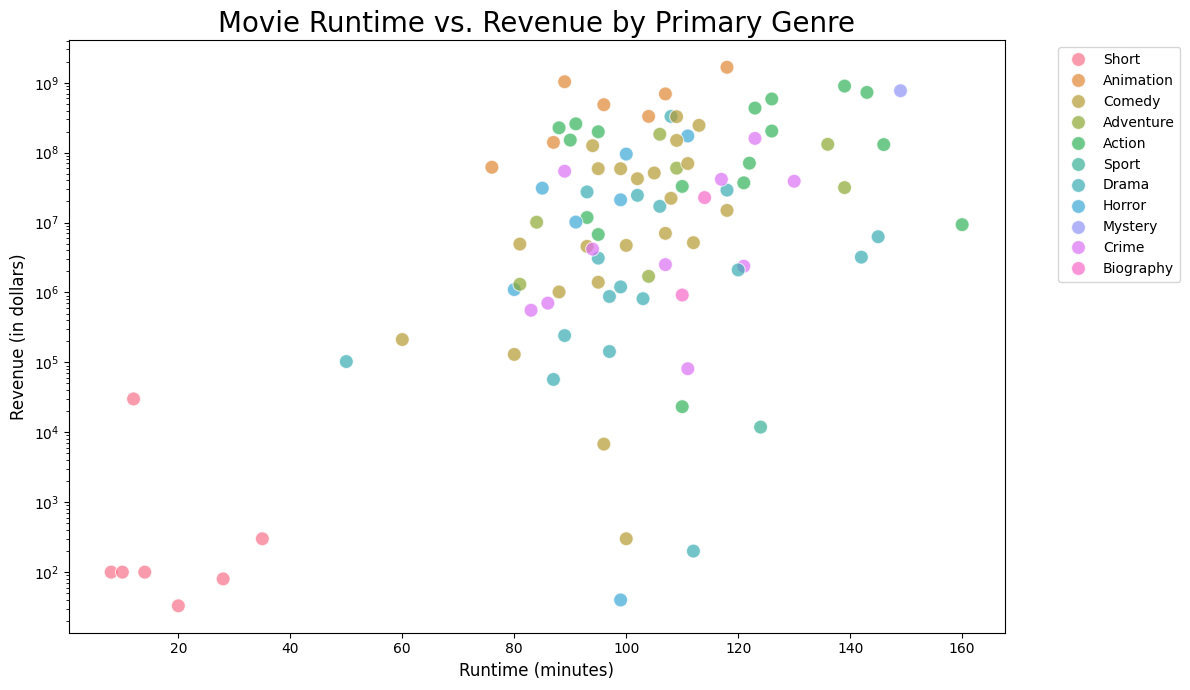

In [59]:
# Query to get runtime vs revenue by genre.
query4 = """
SELECT A.Title, A.Genre, 
       CAST(A.Runtime_min AS INTEGER) as runtime_minutes,
       CAST(REPLACE(REPLACE(F.revenue, '$', ''), ',', '') AS FLOAT) AS revenue_num
FROM api_file A
JOIN flat_file F ON A.imdbID = F.imdb_id
WHERE A.Runtime_min != 'N/A' AND F.revenue != ''
"""
# Store the results of the query in a dataframe.
df4 = pd.read_sql(query4, conn)

# Extracting primary genre for simplicity.
df4['Primary_Genre'] = df4['Genre'].str.split(',').str[0]

# Visualization
plt.figure(figsize=(12,7))
sns.scatterplot(x='runtime_minutes',
                y='revenue_num',
                hue='Primary_Genre',
                data=df4,
                alpha=0.7,
                s=100)
plt.title('Movie Runtime vs. Revenue by Primary Genre', fontsize=20)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Revenue (in dollars)', fontsize=12)
plt.yscale('log') # We are using Log Scale for better visualization.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Visualization 5 - Movie Ratings Distribution by Production Country (api_file + flat_file)

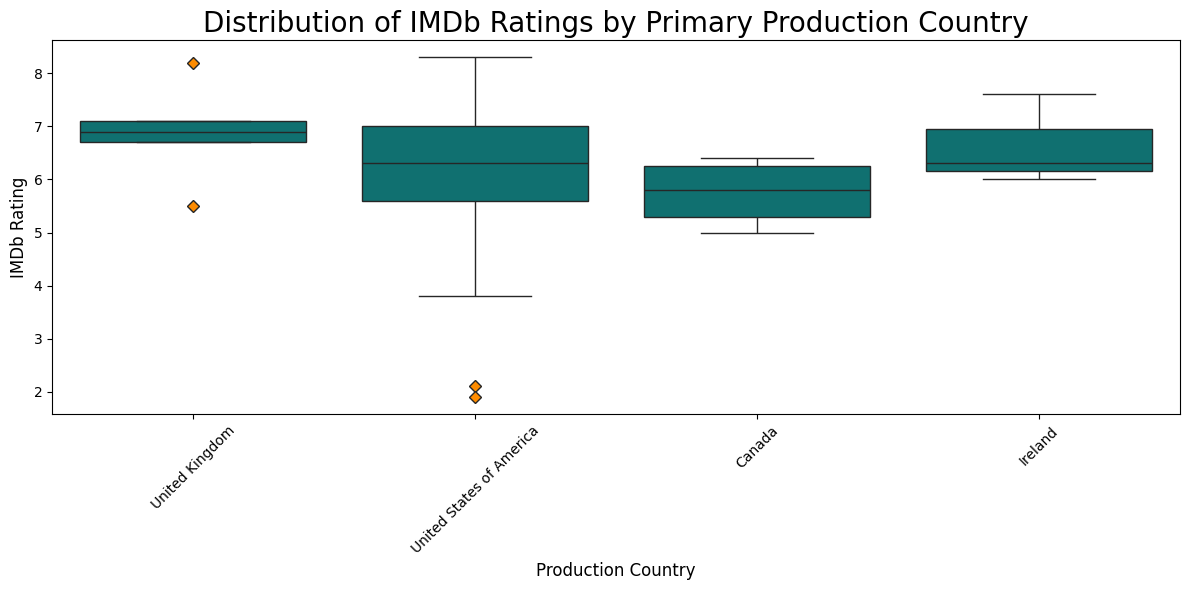

In [60]:
# Query to get ratings by production country.
query5 = """
SELECT a.Title, a.imdbRating, f.production_countries
FROM api_file a
JOIN flat_file f ON a.imdbID = f.imdb_id
WHERE a.imdbRating != 'N/A' AND f.production_countries != ''
"""

# Storing the results of the query in a dataframe.
df5 = pd.read_sql(query5, conn)

# Cleaning and extracting primary production country.
df5['Primary_Country'] = df5['production_countries'].str.split(',').str[0]

# Converting imdbRating to numerical value.
df5['imdbRating'] = pd.to_numeric(df5['imdbRating'])

# Filtering for countries with enough data.
country_counts = df5['Primary_Country'].value_counts()
top_countries = country_counts[country_counts >= 3].index
df5_filtered = df5[df5['Primary_Country'].isin(top_countries)]

# Visualization
plt.figure(figsize=(12,6))
sns.boxplot(x='Primary_Country',
            y='imdbRating',
            color='teal',
            flierprops=dict(markerfacecolor='darkorange', marker='D'), #Outliers
            data=df5_filtered)
plt.title('Distribution of IMDb Ratings by Primary Production Country', fontsize=20)
plt.xlabel('Production Country', fontsize=12)
plt.ylabel('IMDb Rating', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Close the connection to the SQLite database.

In [61]:
# Closing the connection to the SQLite database.
if conn:
    conn.close()

# Datasets

#### Flat File

In [62]:
# Printing the first five rows of the cleaned data frame - Flat File
df_sample.head()

,imdb_id,title,vote_average,status,release_date,runtime,revenue,budget,revenue_variance,homepage,original_language,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages
11395,tt1181614,Wuthering Heights,5.900,Released,2011-09-09,124,"$1,742,215.00","$5,692,172.00",unfavorable,https://www.curzonartificialeye.com/wuthering-...,en,"Yorkshire moorlands, northern England, in the ...",11.745,Love is a force of nature,"Drama, Romance","Ecosse Films, UK Film Council, Film4 Productio...",United Kingdom,English
541,tt1661199,Cinderella,6.798,Released,2015-03-06,105,"$543,514,353.00","$95,000,000.00",favorable,http://movies.disney.com/cinderella,en,"When her father unexpectedly passes away, youn...",58.212,Midnight is just the beginning.,"Romance, Fantasy, Family, Drama","Walt Disney Pictures, Genre Films, Beagle Pug ...","United Kingdom, United States of America",English
7956,tt0102005,Harley Davidson and the Marlboro Man,6.312,Released,1991-08-23,98,"$7,434,726.00","$23,000,000.00",unfavorable,http://www.mgm.com/title_title.do?title_star=H...,en,"It's the lawless future, and renegade biker Ha...",19.835,Who says there are no more heroes?,"Action, Thriller","Krisjair, Laredo, Metro-Goldwyn-Mayer",United States of America,English
17617,tt0047840,Artists and Models,6.800,Released,1955-11-07,110,"$3,800,000.00","$1,500,000.00",favorable,NaN,en,A struggling painter begins taking inspiration...,9.447,"Martin and Lewis run amok with spies, models a...",Comedy,"Hal Wallis Productions, Paramount",United States of America,English
4575,tt0110932,Quiz Show,7.262,Released,1994-08-25,133,"$24,822,619.00","$31,000,000.00",unfavorable,NaN,en,Lawyer Richard Goodwin discovers that 'Twenty-...,13.545,Fifty million people watched but no one saw a ...,"History, Drama, Mystery","Baltimore Pictures, Wildwood Enterprises, Holl...",United States of America,English


#### API File

In [63]:
# Printing the first five rows of the cleaned data frame - API file
df_imdb_api.head()

,Title,Year,Rated,Released,Genre,Director,Writer,Plot,Language,Country,...,Production,Website,Response,Season,Episode,seriesID,Actor 1,Actor 2,Actor 3,Runtime_min
0,Driftwood,2012-01-01,TV-G,2012-11-15,"Short, Drama, Sport",James Webber,James Webber,"Set in London, Driftwood is the story of fifte...",English,United Kingdom,...,N/A,N/A,True,NaN,NaN,NaN,Sam Gittins,Neil Maskell,Daniel Norford,12.0
1,Despicable Me 3,2017-01-01,PG,2017-06-30,"Animation, Adventure, Comedy","Kyle Balda, Pierre Coffin, Eric Guillon","Cinco Paul, Ken Daurio","Gru meets his long-lost, charming, cheerful, a...",English,"United States, France",...,N/A,N/A,True,NaN,NaN,NaN,Steve Carell,Kristen Wiig,Trey Parker,89.0
2,The Story of Us,1999-01-01,R,1999-10-15,"Comedy, Drama, Romance",Rob Reiner,"Alan Zweibel, Jessie Nelson",Ben and Katie Jordan are a married couple who ...,"English, Italian",United States,...,N/A,N/A,True,NaN,NaN,NaN,Bruce Willis,Michelle Pfeiffer,Colleen Rennison,95.0
3,Buddy,1997-01-01,PG,1997-06-06,"Adventure, Comedy, Drama",Caroline Thompson,"Gertrude Davies Lintz, William Joyce, Caroline...",A depiction of the true life story of Gertrude...,English,United States,...,N/A,N/A,True,NaN,NaN,NaN,Rene Russo,Robbie Coltrane,Alan Cumming,84.0
4,The Gods Must Be Crazy,1980-01-01,PG,1984-10-26,"Adventure, Comedy",Jamie Uys,Jamie Uys,A comic allegory about a traveling Bushman who...,"English, Afrikaans, Ungwatsi","South Africa, Botswana",...,N/A,N/A,True,NaN,NaN,NaN,N!xau,Marius Weyers,Sandra Prinsloo,109.0


#### Web File

In [64]:
# Printing the first five rows of the cleaned data frame - Web File
df_films.head()

,Actor,Year,Title,Role
0,Neil Maskell,1997-01-01,Nil by Mouth,Schmuddie
1,Neil Maskell,1997-01-01,Crocodile Snap,Ray
2,Neil Maskell,1998-01-01,Titanic Town,Soldier
3,Neil Maskell,2000-01-01,Sorted,Record Shop Geezer
4,Neil Maskell,2001-01-01,Redemption Road,Leading Mugger


#### Joined Dataset

In [65]:
# Printing the first five rows of the cleaned data frame - Joined Dataset
df_tables_joined.head()

,imdbID,Title,Runtime_min,Year,Rated,Released,Genre,Director,Writer,Plot,...,Actor 2,Total_Movies_A2,Actor 3,Total_Movies_A3,popularity,revenue,budget,revenue_variance,production_companies,production_countries
0,tt2444514,Driftwood,12.0,2012-01-01 00:00:00,TV-G,2012-11-15 00:00:00,"Short, Drama, Sport",James Webber,James Webber,"Set in London, Driftwood is the story of fifte...",...,Neil Maskell,61,Daniel Norford,0,0.600,"$30,000.00","$30,000.00",unfavorable,The Springhead Film Company,United Kingdom
1,tt3469046,Despicable Me 3,89.0,2017-01-01 00:00:00,PG,2017-06-30 00:00:00,"Animation, Adventure, Comedy","Kyle Balda, Pierre Coffin, Eric Guillon","Cinco Paul, Ken Daurio","Gru meets his long-lost, charming, cheerful, a...",...,Kristen Wiig,54,Trey Parker,0,29.104,"$1,031,552,585.00","$80,000,000.00",favorable,"Illumination, Universal Pictures",United States of America
2,tt0160916,The Story of Us,95.0,1999-01-01 00:00:00,R,1999-10-15 00:00:00,"Comedy, Drama, Romance",Rob Reiner,"Alan Zweibel, Jessie Nelson",Ben and Katie Jordan are a married couple who ...,...,Michelle Pfeiffer,1,Colleen Rennison,14,15.488,"$58,900,031.00","$50,000,000.00",favorable,"Universal Pictures, Castle Rock Entertainment,...",United States of America
3,tt0118787,Buddy,84.0,1997-01-01 00:00:00,PG,1997-06-06 00:00:00,"Adventure, Comedy, Drama",Caroline Thompson,"Gertrude Davies Lintz, William Joyce, Caroline...",A depiction of the true life story of Gertrude...,...,Robbie Coltrane,57,Alan Cumming,71,7.084,"$10,113,400.00","$25,000,000.00",unfavorable,"Columbia Pictures, The Jim Henson Company, Jim...",United States of America
4,tt0080801,The Gods Must Be Crazy,109.0,1980-01-01 00:00:00,PG,1984-10-26 00:00:00,"Adventure, Comedy",Jamie Uys,Jamie Uys,A comic allegory about a traveling Bushman who...,...,Marius Weyers,0,Sandra Prinsloo,0,18.957,"$60,000,000.00","$5,000,000.00",favorable,"CAT Films, Mimosa Films","South Africa, Botswana"


# Summary

#### Lessons Learned

Web scrapping was the most difficult part of this project. The flat file and the API were straightforward. 

Tables in Wikipedia are not standard. Some of the rows are merged in the “Year” column (when there are multiple movies in the same year), sometimes the rows are merged in the “Role” column (when an actor plays the same role in different movies, during consecutive years). Some tables have a “Notes” column, but not all. These are just some of the different tables observed.

At first, I was scrapping the tables with BeautifulSoup and trying to manually parse them into Pandas’ data frames, considering all the variations mentioned above. It took a lot of effort and even then, not all the tables worked fine. I learned that Pandas can easily (and automatically) parse these kinds of tables into a data frame, saving a lot of time and making the code more legible.

Another issue found when scrapping web data is that Wikipedia does not follow a standard for the URLs, there are variations. And not all the actors have their filmographies in tables, bringing one more issue.

One more issue was when different people have the same name (and not all of them are actors). There is no universal URL to automatically find the actor.

It would take a lot of time to find and correctly parse all the data for every actor for each one of the 1M+ records in the original dataset.

If I had to start over, I would skip Wikipedia and I’d try to get filmographies from a different website, like IMDB.

## Ethical Implications

#### What changes were made to the data?
Different modifications were done to all three data sources:

**Flat File (original dataset obtained from Kaggle):**
 - Records with no IMDB ID were filtered out, as well as movies classified as adult films, documentaries, those with a primary language other than English, and those without revenue or budget reported.
 - Columns that were not necessary for this project were removed (such as 'id', 'adult', 'backdrop_path', 'original_title', 'poster_path', 'keywords').
 - A new column was added to determine the revenue variance (favorable or unfavorable).
 - All the amounts (revenue and budget)  were formatted as currency.
 - The order of columns were changed.

**API File (created from the responses returned by the OMDB API):**
 - The API returns the names of the top-three actors for a given movie as a single field. This was split into three different fields.
 - After storing all actors in different fields, there was no longer a need for the original field. It was removed.
 - Fields with dates (Year and Released) were converted to datetime objects.
 - Fields Box Office and Runtime were converted to numerical format.

**Wiki File (created from the filmography found in Wikipedia per each one of the actors):**
 - Added a new column with the name of the actor.
 - Normalized column names.
 - Merged all the filmographies into a single data frame.
 - Dropped columns Notes and References.
 - Changed the order of columns.
 - Removed cross-like symbols.

#### Are there any legal or regulatory guidelines for your data or project topic?
No. All the information used here is public, based on the work of actors.

#### What risks could be created based on the transformations done?
The original dataset has more than 1M records. It was filtered down for this exercise. There is a risk of having movies than performed better (either in revenue, IMDB Rating, or any other metric), and have them left out due to the filters used. For example, there could be movies with a IMDB Rating higher than “The Lion King”, but it was excluded of the dataset because its primary language is not English, or there is no data about its revenue or budget.

#### Did you make any assumptions in cleaning/transforming the data?
No assumptions were made; all the information was taken as it is from all the different sources.

#### How was your data sourced / verified for credibility?
This is all public, well-known information about movies and actors.

#### Was your data acquired in an ethical way?
Yes, all the information was obtained in an ethical way using public resources.

#### How would you mitigate any of the ethical implications you have identified?
There are three main reasons why the data was filtered down:
 1) The flat file has more than 1M records. Processing each one of them could take a considerable amount of time.
 2) The API used has a rate limit of 1,000 requests per day, using the free version. In order to get more than that, a commercial key must be obtained.
 3) Scrapping the filmography of every actor from Wikipedia could also take a considerable amount of time, and scrapping all data at once would require additional compute capabilities.

To mitigate all these points, we could pay the commercial key for the API, scrape data from Wikipedia in smaller batches, not all at once (this could take several days), and finally, allocate enough time to process all the 1M+ records in the dataset obtained from Kaggle.

Following these steps, no movie would be left out of these results, regardless of the language, classification, or revenue reported.